<a href="https://colab.research.google.com/github/RudyMartin/yelp/blob/main/%3DYelpReviews_3_LTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Rudy Martin <realrudymartin@gmail.com> (2025-01-07)

Status: Work-in-progress

# Using Learn-to-Rank Recommender Systems for Topic Ranking on Yelp Reviews

Learning-to-Rank (LTR) systems are widely used across various domains to optimize ranking for relevance, personalization, and user satisfaction. Below are real-world applications of LTR systems:

* Ranking search results based on relevance to a user's query.
* Displaying products to maximize conversions, sales, or user engagement.
* Ranking ads for optimal click-through and conversion rates.
* Personalized content recommendations to improve engagement.
* Ranking posts, comments, and connections to boost user engagement.
* Ranking flights, hotels, and destinations for better booking.
experiences.
* Ranking treatment options, doctors, or research papers for better decision-making.
* and more ...



Let's try this for topic discovery on a noisy dataset:

The initial dataset contains the following columns:

1. Yelp URL: The unique identifier for each restaurant.
2.  Rating: User ratings (1-5 stars).
3.  Date: When the review was written.
4.  Review Text: The content of the review.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

data_dir = '/content/drive/My Drive/yelp/'
data_path = f'{data_dir}Yelp Restaurant Reviews.csv'
data = pd.read_csv(data_path)

Mounted at /content/drive


In [ ]:
# Install any missing dependencies here
#!pip install lightgbm

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
from textblob import TextBlob

In [7]:
# Preprocess Data
data['Date'] = pd.to_datetime(data['Date'])
data['Review_Length'] = data['Review Text'].str.len()
data['Group'] = data['Yelp URL'].factorize()[0]

# for cost/time reasons just focus on the two years before and the year after March 2020 (see ratings history notebook for details)
data = data[(data['Date'] >= '2018-03-01') & (data['Date'] <= '2022-02-28')]  # Limiting data around March 2020

# Calculate sentiment scores before the split
data['Sentiment'] = data['Review Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Scrub Data (Drop missing values)
data = data.dropna(subset=['Date', 'Review Text', 'Rating', 'Review_Length','Sentiment'])

# Split Data by Period
data['Pre_March_2020'] = data['Date'] < pd.to_datetime('2020-03-01')
pre_march_data = data[data['Pre_March_2020']]
post_march_data = data[~data['Pre_March_2020']]


#BM25 Implementation
class BM25:
    def __init__(self, b=0.75, k1=1.6):
        self.b = b
        self.k1 = k1

    def fit(self, corpus):
        self.corpus = corpus
        self.avgdl = sum(map(len, corpus)) / len(corpus)

    def score(self, query):
        bm25_scores = []
        for doc in self.corpus:
            score = 0
            for term in query:
                if term in doc:
                    tf = doc.count(term)
                    idf = np.log((len(self.corpus) - sum([1 for x in self.corpus if term in x]) + 0.5) / (sum([1 for x in self.corpus if term in x]) + 0.5) + 1)
                    score += idf * (tf * (self.k1 + 1)) / (tf + self.k1 * (1 - self.b + self.b * (len(doc) / self.avgdl)))
            bm25_scores.append(score)
        return bm25_scores

# Example query (replace with actual query)
query = "good food service"
query = query.split()

# Initialize and fit BM25
bm25_model = BM25()

# Function to prepare data and calculate BM25 scores
def prepare_data_with_bm25(data):
    corpus = [doc.lower().split() for doc in data['Review Text']]
    bm25_model.fit(corpus)
    bm25_scores = bm25_model.score(query)
    data['BM25_Score'] = bm25_scores
    return data

# Apply to pre and post data
pre_march_data_bm25 = prepare_data_with_bm25(pre_march_data.copy())
post_march_data_bm25 = prepare_data_with_bm25(post_march_data.copy())

# Define Training Function (Updated)
def train_ltr(data, features, labels):
    # Feature matrix and labels
    X = data[features]
    y = data[labels]

    # Drop rows with NaN or infinite values
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y.replace([np.inf, -np.inf], np.nan).dropna()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Recalculate group sizes
    train_group = [len(X_train)]
    test_group = [len(X_test)]

    # Create LightGBM datasets
    lgb_train = lgb.Dataset(X_train, label=y_train, group=train_group)
    lgb_test = lgb.Dataset(X_test, label=y_test, group=test_group)

    # LightGBM parameters
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }

    # Train the model with early stopping
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test'],
        num_boost_round=100,
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    return model, X_test, y_test

data


,Yelp URL,Rating,Date,Review Text,Review_Length,Group,Sentiment,Pre_March_2020
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,2022-01-22,All I can say is they have very good ice cream...,123,0,0.773333,False
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,2021-08-07,A delicious treat on a hot day! Staff was very...,131,0,0.268750,False
5,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,2019-05-01,I've been coming to this ice cream stand since...,754,0,0.165062,True
9,https://www.yelp.com/biz/sidney-dairy-barn-sidney,2,2019-07-26,Went here for the 1st time tonight. I ordered ...,599,0,0.163247,True
11,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,2018-05-18,Best ice cream in the area! I love their featu...,145,0,0.522500,True
...,...,...,...,...,...,...,...,...
19891,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,2021-07-17,Had the chocolate cannoli! The filling was ric...,120,47,0.458333,False
19892,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,2019-10-21,Love apricot croissant! I bought it at 4:00 PM...,352,47,0.498558,True
19893,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,2019-10-12,Line was about 25 people long. It went fast! T...,356,47,0.397143,True
19894,https://www.yelp.com/biz/la-pasticceria-las-vegas,5,2021-04-11,Its hard not to order everything when I come h...,168,47,0.204167,False


In [14]:
def train_ltr(data, features, labels, params=None):
    """
    Trains a LightGBM LambdaRank model with dynamic group size handling.

    Args:
        data (DataFrame): Input training data, including 'Group' column.
        features (list): Feature column names.
        labels (str): Target column name.
        params (dict): LightGBM parameters (optional).

    Returns:
        model: Trained LightGBM model.
        X_test, y_test: Test data features and labels.
    """
    from sklearn.model_selection import train_test_split
    import lightgbm as lgb

    # Define default parameters if not provided
    if params is None:
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'boosting_type': 'gbdt',
            'learning_rate': 0.1,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
        }

    # Ensure 'Group' column exists
    if 'Group' not in data.columns:
        data['Group'] = 0  # Default group for all rows

    # Prepare features and labels
    X = data[features]
    y = data[labels]

    # Group sizes
    group_sizes = data.groupby('Group').size().tolist()

    # Train-test split (split by groups)
    group_ids = data['Group'].unique()
    train_groups, test_groups = train_test_split(group_ids, test_size=0.2, random_state=42)
    train_data = data[data['Group'].isin(train_groups)]
    test_data = data[data['Group'].isin(test_groups)]

    # Recompute group sizes for train and test data
    group_train_sizes = train_data.groupby('Group').size().tolist()
    group_test_sizes = test_data.groupby('Group').size().tolist()

    # Prepare training and testing datasets
    X_train, y_train = train_data[features], train_data[labels]
    X_test, y_test = test_data[features], test_data[labels]

    lgb_train = lgb.Dataset(X_train, label=y_train, group=group_train_sizes)
    lgb_test = lgb.Dataset(X_test, label=y_test, group=group_test_sizes)

    # Train the model
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test'],
        num_boost_round=100,
        callbacks=[lgb.early_stopping(stopping_rounds=10)],
    )

    return model, X_test, y_test


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 4302, number of used features: 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

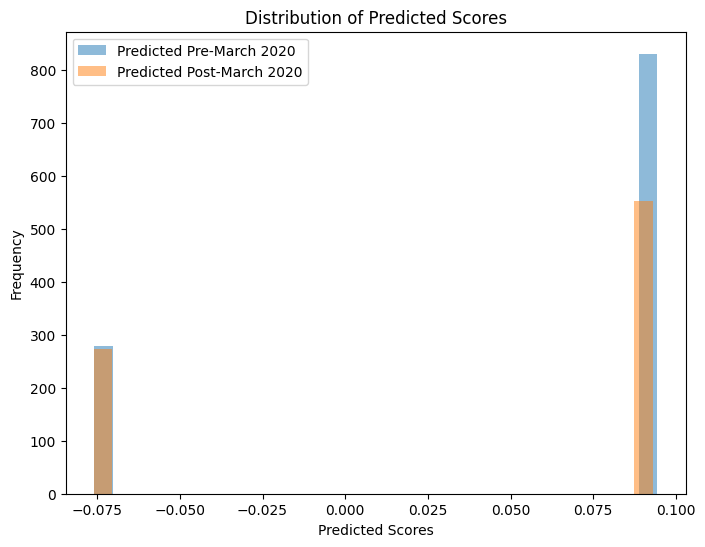

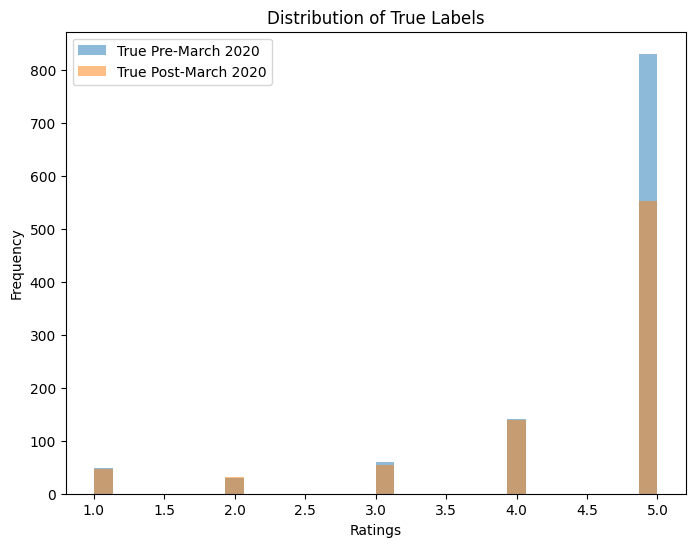

In [17]:
# Train Models with Regularization
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
}

pre_march_model, X_test_pre, y_test_pre = train_ltr(pre_march_data_bm25, features, labels, params=params)
post_march_model, X_test_post, y_test_post = train_ltr(post_march_data_bm25, features, labels, params=params)

# Evaluate Rankings
y_pred_pre = evaluate_rankings(pre_march_model, X_test_pre, y_test_pre)
y_pred_post = evaluate_rankings(post_march_model, X_test_post, y_test_post)

# Compare Rankings
# Evaluate Kendall's Tau for each dataset independently
kendall_tau_pre, p_value_pre = kendalltau(y_test_pre, y_pred_pre)
kendall_tau_post, p_value_post = kendalltau(y_test_post, y_pred_post)

print(f"Pre-March Kendall's Tau: {kendall_tau_pre}, p-value: {p_value_pre}")
print(f"Post-March Kendall's Tau: {kendall_tau_post}, p-value: {p_value_post}")


# Analyze Feature Importance
print("Feature Importance (Pre-March Model):")
for feature, importance in zip(features, pre_march_model.feature_importance(importance_type='gain')):
    print(f"Feature: {feature}, Importance: {importance}")

print("Feature Importance (Post-March Model):")
for feature, importance in zip(features, post_march_model.feature_importance(importance_type='gain')):
    print(f"Feature: {feature}, Importance: {importance}")

# Visualize Predictions and True Labels
plt.figure(figsize=(8, 6))
plt.hist(y_pred_pre, bins=30, alpha=0.5, label='Predicted Pre-March 2020')
plt.hist(y_pred_post, bins=30, alpha=0.5, label='Predicted Post-March 2020')
plt.title('Distribution of Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(y_test_pre, bins=30, alpha=0.5, label='True Pre-March 2020')
plt.hist(y_test_post, bins=30, alpha=0.5, label='True Post-March 2020')
plt.title('Distribution of True Labels')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.legend()
plt.show()